TODO:
    - Stack all three years of tracking data
    - Train/test split
    - Sort by y value(?)
    - Standardize punt directional data(?)

In [1]:
%matplotlib notebook

In [2]:
from types import SimpleNamespace

import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

COLUMN = SimpleNamespace(**{
    'PLAY_TYPE': 'specialTeamsPlayType',
    'SPECIAL_TEAMS_RESULT': 'specialTeamsResult',
    'PLAY_RESULT': 'playResult', # Net difference in field position
    'POSITION': 'position',
    'PLAY_EVENT': 'event',
    'GAME_ID': 'gameId',
    'PLAY_ID': 'playId',
    'GUNNERS': 'gunners',
    'GUNNER_LIST': 'gunnerList',
    'HOME_TEAM': 'homeTeamAbbr',
    'VISITOR_TEAM': 'visitorTeamAbbr',
    'IS_GUNNER': 'isGunner',
    'JERSEY_NUMBER': 'jerseyNumber',
    'TEAM': 'team',
    'POSSESSION_TEAM': 'possessionTeam',
    'TIME': 'time',
    'NFL_ID': 'nflId',
    'RETURNER_ID': 'returnerId',
    'PRIMARY_RETURNER_ID': 'primaryReturnerId',
    'PLAYER_TEAM_ID': 'playerTeamId',
    'X': 'x',
    'Y': 'y',
    'COLOR': 'color',
    'FRAME': 'frame',
    'DISPLAY_NAME': 'displayName',
    'KICK_RETURN_YARDAGE': 'kickReturnYardage',
    'DISTANCE_FROM_SIDELINE': 'distanceFromSideline',
    'SORT_POSITION': 'sortPosition',
})

POSITION = SimpleNamespace(**{
    'KICKER': 'K',
    'PUNTER': 'P',
    'LONG_SNAPPER': 'LS',
})

PLAY_TYPE = SimpleNamespace(**{
    'FIELD_GOAL': 'Field Goal',
    'PUNT': 'Punt',
})

PLAY_EVENT = SimpleNamespace(**{
    'BALL_SNAP': 'ball_snap',
    'FG_ATTEMPT': 'field_goal_attempt',
    'PUNT': 'punt',
    'PUNT_RECEIVED': 'punt_received',
    'OUT_OF_BOUNDS': 'out_of_bounds',
    'PUNT_LAND': 'punt_land',
    'FAIR_CATCH': 'fair_catch',
    'PUNT_MUFFED': 'punt_muffed',
})

SPECIAL_TEAMS_RESULT = SimpleNamespace(**{
    'BLOCKED': 'Blocked Kick Attempt',
    'DOWNED': 'Downed',
    'KICK_GOOD': 'Kick Attempt Good',
    'KICK_NO_GOOD': 'Kick Attempt No Good',
    'RETURN': 'Return',
    'TOUCHBACK': 'Touchback',
    'FAIR_CATCH': 'Fair Catch',
    'MUFFED': 'Muffed',
    'OUT_OF_BOUNDS': 'Out of Bounds',
})

TEAM = SimpleNamespace(**{
    'HOME': 'home',
    'AWAY': 'away',
    'FOOTBALL': 'football',
})

In [3]:
games_df = pd.read_csv('input/games.csv')
players_df = pd.read_csv('input/players.csv')
plays_df = pd.read_csv('input/plays.csv')
pff_scouting_df = pd.read_csv('input/PFFScoutingData.csv')
tracking_2018_df = pd.read_csv('input/tracking2018.csv')
tracking_2019_df = pd.read_csv('input/tracking2019.csv')
tracking_2020_df = pd.read_csv('input/tracking2020.csv')
tracking_df = pd.concat([tracking_2018_df, tracking_2019_df, tracking_2020_df], ignore_index=True)
game_plays_df = pd.merge(games_df, plays_df, left_on=COLUMN.GAME_ID, right_on=COLUMN.GAME_ID)

In [4]:
game_plays_df = game_plays_df.dropna(subset=[COLUMN.RETURNER_ID])

def getPrimaryReturnerId(value):
    returners = str(value).split(';')
    return int(returners[0])

game_plays_df[COLUMN.PRIMARY_RETURNER_ID] = game_plays_df[COLUMN.RETURNER_ID] \
    .apply(getPrimaryReturnerId) \
    .astype('Int64')

tracking_2018_df[COLUMN.TIME] = pd.to_datetime(tracking_2018_df[COLUMN.TIME])
tracking_2018_df[COLUMN.JERSEY_NUMBER] = tracking_2018_df[COLUMN.JERSEY_NUMBER].astype('Int64')
tracking_2018_df[COLUMN.NFL_ID] = tracking_2018_df[COLUMN.NFL_ID].astype('Int64')

In [5]:
punt_tracking_2018_df = pd.merge(
    pff_scouting_df,
    tracking_2018_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)
punt_plays_df = game_plays_df[game_plays_df[COLUMN.PLAY_TYPE] == PLAY_TYPE.PUNT]
punt_tracking_2018_df = pd.merge(
    punt_tracking_2018_df,
    punt_plays_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

In [6]:
conditions = [
    (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.HOME),
    (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.AWAY),
]

values = [
    punt_tracking_2018_df[COLUMN.HOME_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
    punt_tracking_2018_df[COLUMN.VISITOR_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
]

punt_tracking_2018_df[COLUMN.PLAYER_TEAM_ID] = np.select(conditions, values)

def splitGunners(value):
    if value is None:
        return []
    gunners = str(value).split(';')
    return [gunner.strip() for gunner in gunners]

punt_tracking_2018_df[COLUMN.GUNNER_LIST] = punt_tracking_2018_df[COLUMN.GUNNERS].apply(splitGunners)

punt_tracking_2018_df[COLUMN.IS_GUNNER] = punt_tracking_2018_df.apply(
    lambda x: str(x[COLUMN.PLAYER_TEAM_ID]) in x[COLUMN.GUNNER_LIST],
    axis=1,
)

<IPython.core.display.Javascript object>


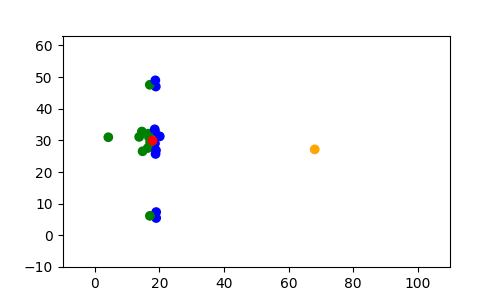

In [7]:
punt_tracking_2018_df.loc[:, COLUMN.FRAME] = punt_tracking_2018_df[[COLUMN.GAME_ID, COLUMN.TIME]] \
    .apply(tuple, axis=1) \
    .rank(ascending=True, method='dense')

is_returner = np.where(punt_tracking_2018_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == punt_tracking_2018_df[COLUMN.NFL_ID].fillna(-2), True, False)

conditions = [
#     punt_tracking_2018_df[COLUMN.IS_GUNNER],
    is_returner,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.HOME,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.AWAY,
    punt_tracking_2018_df[COLUMN.TEAM] == TEAM.FOOTBALL,
]
values = [
    'orange',
    'green',
    'blue',
    'red',
]
punt_tracking_2018_df.loc[:, COLUMN.COLOR] = np.select(conditions, values)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
first_frame = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == 1]
c = first_frame[COLUMN.COLOR]
x = first_frame[COLUMN.X]
y = first_frame[COLUMN.Y]
scatter = ax.scatter(x, y, c=c)

def animate(i):
    filtered = punt_tracking_2018_df[punt_tracking_2018_df[COLUMN.FRAME] == i+1]
    c = filtered[COLUMN.COLOR]
    x = filtered[COLUMN.X]
    y = filtered[COLUMN.Y]
    data = np.c_[x, y]
    scatter.set_offsets(data)
    scatter.set_color(c)

animation = anm.FuncAnimation(
    fig,
    animate,
    interval=10,
    frames=int(punt_tracking_2018_df[COLUMN.FRAME].max()),
    repeat=True,
)
plt.show()

In [8]:
# Punt distance from sideline vs return distance
punt_tracking_2018_df['sidelineA'] = 53.3 - punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df['sidelineB'] = punt_tracking_2018_df[COLUMN.Y]
punt_tracking_2018_df[COLUMN.DISTANCE_FROM_SIDELINE] = punt_tracking_2018_df[['sidelineA', 'sidelineB']].min(axis=1)

<IPython.core.display.Javascript object>


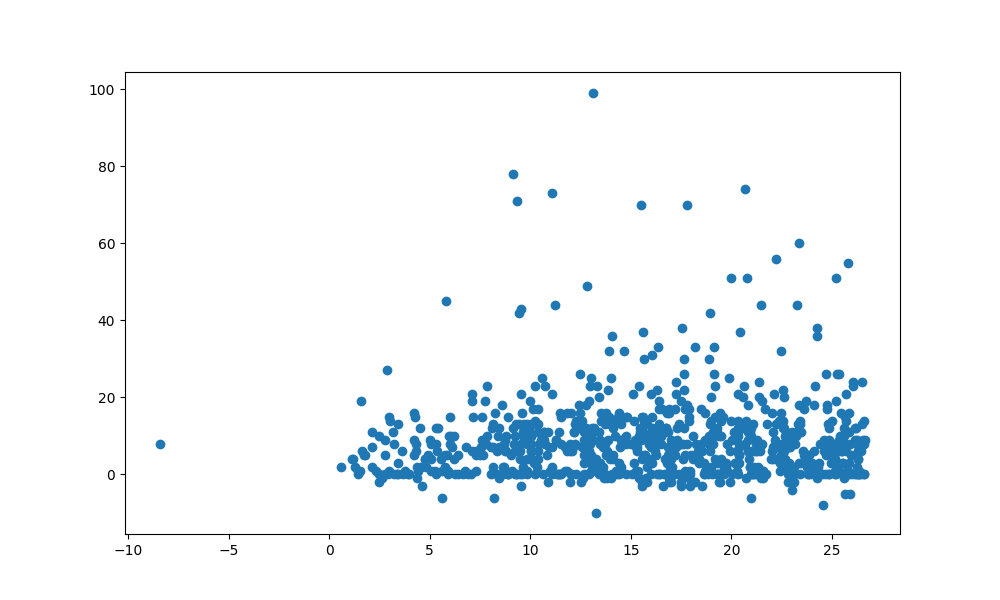

In [9]:
punt_received_football_only_df = punt_tracking_2018_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.PUNT_RECEIVED)
    & (punt_tracking_2018_df[COLUMN.TEAM] == 'football')
]
x = punt_received_football_only_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [10]:
x.corr(y)

0.035468871186775344

In [11]:
punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()

8.923543689320388

In [12]:
punt_received_football_only_df['aboveAverageReturn'] = \
    punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE] > punt_received_football_only_df[COLUMN.KICK_RETURN_YARDAGE].mean()
punt_received_football_only_df[
    [COLUMN.X, COLUMN.Y, COLUMN.DISTANCE_FROM_SIDELINE, COLUMN.KICK_RETURN_YARDAGE, 'aboveAverageReturn']
].head()

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/3108297030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punt_received_football_only_df['aboveAverageReturn'] = \


,x,y,distanceFromSideline,kickReturnYardage,aboveAverageReturn
2893,72.61,39.18,14.12,5.0,False
7911,91.77,35.94,17.36,8.0,False
12720,82.02,42.04,11.26,9.0,True
19308,30.37,32.33,20.97,12.0,True
22523,36.61,44.87,8.43,-1.0,False


<IPython.core.display.Javascript object>


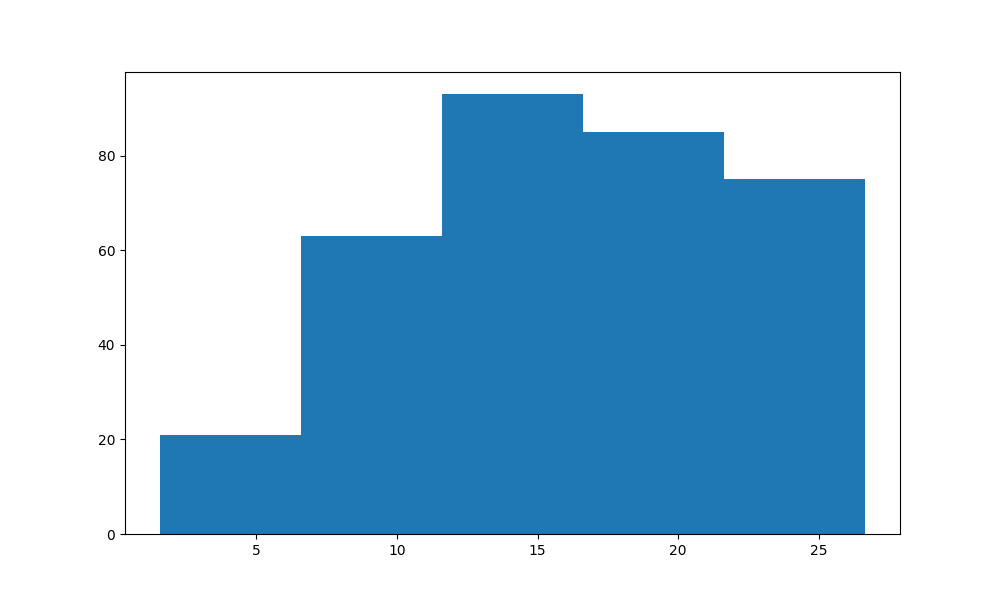

In [13]:
above_average_returns_df = punt_received_football_only_df[punt_received_football_only_df['aboveAverageReturn'] == True]
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
bins = 5
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(x=x, bins=bins)
plt.show()

In [14]:
above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE].corr(above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE])

0.04671642827966678

<IPython.core.display.Javascript object>


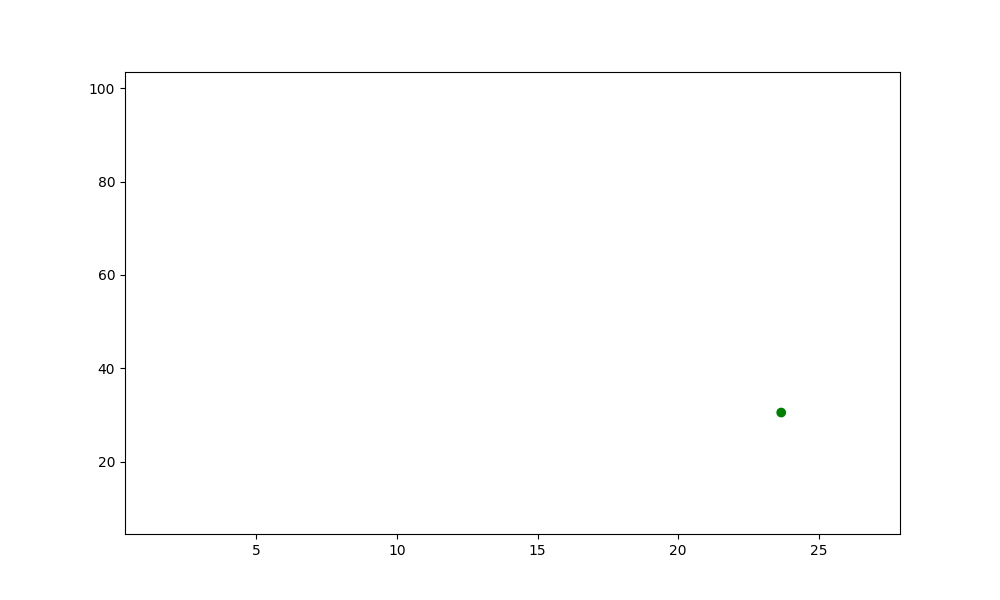

In [15]:
x = above_average_returns_df[COLUMN.DISTANCE_FROM_SIDELINE]
y = above_average_returns_df[COLUMN.KICK_RETURN_YARDAGE]
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x, y)
plt.show()

In [16]:
'''
Predict punt landing position based on pre-snap inputs (e.g. ball position)

Inputs:
  - Positions of all players and ball at time of snap (22 players + ball, x and y positions)
Outputs:
  - Ball landing position x, y
  
TODO:
  - Stack all 3 years of data
  - For inputs, filter tracking data to play event = ball_snap and special teams result
       is one of Return', 'Touchback', 'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
  - For outputs, filter to football position when special teams result is one of Return', 'Touchback',
       'Fair Catch', 'Downed', 'Muffed', 'Out of Bounds'
       AND play event is one of punt_received, punt_land,
       fair_catch, punt_muffed
       AND team is football
  - Partition/sync inputs and outputs based on game id and play id
  - Partition data into training data and test data (80/20)
  - Use sklearn.linear_model.LinearRegression to train and test
  - Visualize results
  
A, B, C, D, E, F

A * x0 + B * x1 + C * x2 + D * x3 ... = ball landing position

                      SORT
x0 = ball x           1
x1 = ball y           2
x2 = punter x
x3 = punter y
x4 = returner x
x5 = returner y
x6 = player3 x
x7 = player3 y
etc...

y0 = ball landing x
y1 = ball landing y

football filter COLUMN.TEAM == 'football'
punter filter COLUMN.POSITION == 'P'
returner filter returnerId == nflId 
'''
special_teams_results = [
    SPECIAL_TEAMS_RESULT.RETURN,
    SPECIAL_TEAMS_RESULT.TOUCHBACK,
    SPECIAL_TEAMS_RESULT.FAIR_CATCH,
    SPECIAL_TEAMS_RESULT.DOWNED,
    SPECIAL_TEAMS_RESULT.MUFFED,
    SPECIAL_TEAMS_RESULT.OUT_OF_BOUNDS,
]
ball_land_events = [
    PLAY_EVENT.PUNT_RECEIVED,
    PLAY_EVENT.PUNT_LAND,
    PLAY_EVENT.FAIR_CATCH,
    PLAY_EVENT.PUNT_MUFFED,
]
punt_predict_df = punt_tracking_2018_df[
    punt_tracking_2018_df[COLUMN.SPECIAL_TEAMS_RESULT].isin(special_teams_results)
]

In [50]:
is_football = punt_predict_df[COLUMN.TEAM] == TEAM.FOOTBALL
is_punter = punt_predict_df[COLUMN.POSITION] == POSITION.PUNTER
is_returner = (~np.isnan(punt_predict_df[COLUMN.PRIMARY_RETURNER_ID])) \
    & (~np.isnan(punt_predict_df[COLUMN.NFL_ID])) \
    & (punt_predict_df[COLUMN.PRIMARY_RETURNER_ID] == punt_predict_df[COLUMN.NFL_ID])
inputs_df = punt_predict_df[
    (punt_predict_df[COLUMN.PLAY_EVENT] == PLAY_EVENT.BALL_SNAP)
    # & ((is_football) | (is_punter) | (is_returner))
    # & (punt_predict_df[COLUMN.RETURNER_ID].str.contains(';') == False) # filter out multiple returner scenarios
]

conditions = [
    (inputs_df[COLUMN.TEAM] == TEAM.FOOTBALL),
    (inputs_df[COLUMN.POSITION] == POSITION.PUNTER),
    np.where(inputs_df[COLUMN.PRIMARY_RETURNER_ID].fillna(-1) == inputs_df[COLUMN.NFL_ID].fillna(-2), True, False),
]
values = [1, 2, 3]
inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/3143725473.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df[COLUMN.SORT_POSITION] = np.select(conditions, values)


In [58]:
inputs_df['remainingSortLocation'] = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID])[COLUMN.GAME_ID].rank(method='first')
inputs_df['remainingSortLocation'] = inputs_df['remainingSortLocation'] + 3
inputs_df['sortValue'] = np.where(
    inputs_df[COLUMN.SORT_POSITION] > 0,
    inputs_df[COLUMN.SORT_POSITION],
    inputs_df['remainingSortLocation'],
)

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/650655266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df['remainingSortLocation'] = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID])[COLUMN.GAME_ID].rank(method='first')
/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_3422/650655266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_df['remainingSortLocation'] = inputs_df['remainingSortLocation'] + 3
/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,playDirection,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,primaryReturnerId,playerTeamId,gunnerList,isGunner,frame,color,sidelineA,sidelineB,distanceFromSideline,sortPosition,remainingSortLocation,sortValue
10,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC,2018-09-07 01:18:15.000,13.76,31.14,0.00,0.00,0.00,66.97,124.26,ball_snap,32361,Corey Graham,24,FS,home,11,right,2018,1,09/06/2018,20:20:00,PHI,ATL,"(9:20) C.Johnston punts 56 yards to ATL 36, Center-R.Lovato. J.Hardy to ATL 41 for 5 yards (K.Grugier-Hill). PENALTY on PHI-S.Gibson, Unsportsmanlike Conduct, 15 yards, enforced at ATL 41.",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18,42450,PHI 24,"[PHI 18, PHI 29]",False,11.0,green,22.16,31.14,22.16,0,4.0,4.0
138,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC,2018-09-07 01:18:15.000,18.54,33.06,0.48,1.08,0.04,245.07,159.55,ball_snap,38707,Justin Bethel,28,CB,away,11,right,2018,1,09/06/2018,20:20:00,PHI,ATL,"(9:20) C.Johnston punts 56 yards to ATL 36, Center-R.Lovato. J.Hardy to ATL 41 for 5 yards (K.Grugier-Hill). PENALTY on PHI-S.Gibson, Unsportsmanlike Conduct, 15 yards, enforced at ATL 41.",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18,42450,ATL 28,"[PHI 18, PHI 29]",False,11.0,blue,20.24,33.06,20.24,0,5.0,5.0
266,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC,2018-09-07 01:18:15.000,19.00,5.47,0.00,0.00,0.00,284.57,218.54,ball_snap,39968,Desmond Trufant,21,CB,away,11,right,2018,1,09/06/2018,20:20:00,PHI,ATL,"(9:20) C.Johnston punts 56 yards to ATL 36, Center-R.Lovato. J.Hardy to ATL 41 for 5 yards (K.Grugier-Hill). PENALTY on PHI-S.Gibson, Unsportsmanlike Conduct, 15 yards, enforced at ATL 41.",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18,42450,ATL 21,"[PHI 18, PHI 29]",False,11.0,blue,47.83,5.47,5.47,0,6.0,6.0
394,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC,2018-09-07 01:18:15.000,18.71,25.62,0.00,0.00,0.05,260.72,240.71,ball_snap,40191,Kemal Ishmael,36,FS,away,11,right,2018,1,09/06/2018,20:20:00,PHI,ATL,"(9:20) C.Johnston punts 56 yards to ATL 36, Center-R.Lovato. J.Hardy to ATL 41 for 5 yards (K.Grugier-Hill). PENALTY on PHI-S.Gibson, Unsportsmanlike Conduct, 15 yards, enforced at ATL 41.",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18,42450,ATL 36,"[PHI 18, PHI 29]",False,11.0,blue,27.68,25.62,25.62,0,7.0,7.0
522,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC,2018-09-07 01:18:15.000,16.39,27.64,0.01,0.01,0.01,80.42,64.71,ball_snap,40408,LaRoy Reynolds,50,MLB,home,11,right,2018,1,09/06/2018,20:20:00,PHI,ATL,"(9:20) C.Johnston punts 56 yards to ATL 36, Center-R.Lovato. J.Hardy to ATL 41 for 5 yards (K.Grugier-Hill). PENALTY on PHI-S.Gibson, Unsportsmanlike Conduct, 15 yards, enforced at ATL 41.",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-

In [59]:
inputs_df = inputs_df.sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'sortValue'])

aggs = { 'x': lambda x: x.to_list(), 'y': lambda y: y.to_list() }
inputs_df = inputs_df.groupby([COLUMN.GAME_ID, COLUMN.PLAY_ID]).agg(aggs).reset_index()
inputs_df = inputs_df[
    (inputs_df[COLUMN.X].map(len) == 23)
    & (inputs_df[COLUMN.Y].map(len) == 23)
]
# Filter out plays where returner is near line of scrimmage
inputs_df = inputs_df[
    np.abs(inputs_df[COLUMN.X].str[0] - inputs_df[COLUMN.X].str[2]) > 10
]

def merge_coordinates(df):
    merged = []
    for i in range(23):
        merged.append(df[COLUMN.X][i])
        merged.append(df[COLUMN.Y][i])
    return merged

inputs_df['features'] = inputs_df.apply(merge_coordinates, axis=1)
inputs_df.head()

,gameId,playId,x,y,features
0,2018090600,366,"[17.9, 4.2, 67.05, 13.76, 18.54, 19.0, 18.71, 16.39, 16.76, 17.49, 14.56, 16.51, 19.02, 18.91, 17.02, 18.65, 17.09, 18.27, 14.79, 17.06, 20.12, 18.75, 18.41]","[29.94, 31.01, 26.31, 31.14, 33.06, 5.47, 25.62, 27.64, 31.01, 29.97, 32.83, 32.14, 7.34, 47.03, 47.57, 29.03, 29.37, 26.84, 26.57, 6.16, 31.29, 49.0, 33.63]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31, 13.76, 31.14, 18.54, 33.06, 19.0, 5.47, 18.71, 25.62, 16.39, 27.64, 16.76, 31.01, 17.49, 29.97, 14.56, 32.83, 16.51, 32.14, 19.02, 7.34, 18.91, 47.03, 17.02, 47.57, 18.65, 29.03, 17.09, 29.37, 18.27, 26.84, 14.79, 26.57, 17.06, 6.16, 20.12, 31.29, 18.75, 49.0, 18.41, 33.63]"
1,2018090600,973,"[20.8, 7.04, 68.89, 19.74, 17.61, 20.68, 21.27, 21.06, 21.46, 16.04, 20.49, 19.23, 23.01, 21.23, 19.68, 21.44, 17.67, 19.37, 21.25, 21.49, 21.77, 19.83, 19.36]","[29.88, 29.32, 34.84, 5.97, 27.96, 31.9, 31.04, 35.38, 29.31, 28.64, 29.55, 31.72, 45.81, 33.68, 28.74, 27.84, 31.84, 30.71, 26.11, 25.32, 6.36, 46.06, 28.08]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84, 19.74, 5.97, 17.61, 27.96, 20.68, 31.9, 21.27, 31.04, 21.06, 35.38, 21.46, 29.31, 16.04, 28.64, 20.49, 29.55, 19.23, 31.72, 23.01, 45.81, 21.23, 33.68, 19.68, 28.74, 21.44, 27.84, 17.67, 31.84, 19.37, 30.71, 21.25, 26.11, 21.49, 25.32, 21.77, 6.36, 19.83, 46.06, 19.36, 28.08]"
2,2018090600,1989,"[35.82, 22.04, 85.21, 35.09, 32.44, 36.94, 36.61, 38.61, 36.34, 30.72, 35.47, 34.45, 37.2, 36.17, 34.64, 36.44, 32.63, 34.44, 36.36, 36.87, 36.87, 34.99, 34.33]","[23.79, 23.28, 28.81, 6.01, 21.67, 24.54, 26.34, 22.53, 21.12, 22.42, 23.74, 25.44, 42.59, 27.66, 22.93, 22.53, 25.86, 24.58, 19.63, 5.36, 7.23, 43.26, 22.04]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81, 35.09, 6.01, 32.44, 21.67, 36.94, 24.54, 36.61, 26.34, 38.61, 22.53, 36.34, 21.12, 30.72, 22.42, 35.47, 23.74, 34.45, 25.44, 37.2, 42.59, 36.17, 27.66, 34.64, 22.93, 36.44, 22.53, 32.63, 25.86, 34.44, 24.58, 36.36, 19.63, 36.87, 5.36, 36.87, 7.23, 34.99, 43.26, 34.33, 22.04]"
3,2018090600,2406,"[68.43, 81.79, 20.34, 72.24, 67.69, 66.96, 67.62, 70.09, 69.28, 68.66, 71.76, 69.72, 65.73, 65.96, 68.99, 67.52, 69.05, 67.77, 71.72, 69.05, 67.66, 65.74, 67.74]","[29.6, 28.88, 31.25, 28.92, 27.32, 46.9, 31.43, 32.27, 28.92, 29.92, 27.05, 27.81, 32.19, 26.85, 7.09, 32.99, 30.41, 34.78, 33.11, 47.09, 25.72, 7.39, 28.56]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25, 72.24, 28.92, 67.69, 27.32, 66.96, 46.9, 67.62, 31.43, 70.09, 32.27, 69.28, 28.92, 68.66, 29.92, 71.76, 27.05, 69.72, 27.81, 65.73, 32.19, 65.96, 26.85, 68.99, 7.09, 67.52, 32.99, 69.05, 30.41, 67.77, 34.78, 71.72, 33.11, 69.05, 47.09, 67.66, 25.72, 65.74, 7.39, 67.74, 28.56]"
4,2018090600,2599,"[36.0, 22.03, 81.78, 35.3, 33.02, 36.46, 37.0, 39.12, 36.42, 31.38, 35.63, 34.65, 37.24, 36.79, 35.1, 36.6, 33.08, 34.82, 36.68, 36.92, 36.94, 35.19, 34.93]","[26.47, 26.11, 29.42, 6.27, 24.38, 27.59, 28.81, 25.08, 23.54, 25.1, 26.46, 28.18, 44.1, 30.46, 25.49, 25.23, 28.55, 27.27, 22.07, 5.35, 7.49, 44.29, 24.63]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42, 35.3, 6.27, 33.02, 24.38, 36.46, 27.59, 37.0, 28.81, 39.12, 25.08, 36.42, 23.54, 31.38, 25.1, 35.63, 26.46, 34.65, 28.18, 37.24, 44.1, 36.79, 30.46, 35.1, 25.49, 36.6, 25.23, 33.08, 28.55, 34.82, 27.27, 36.68, 22.07, 36.92, 5.35, 36.94, 7.49, 35.19, 44.29, 34.93, 24.63]"


In [65]:
outputs_df = punt_predict_df[
    (punt_tracking_2018_df[COLUMN.PLAY_EVENT].isin(ball_land_events))
    & (punt_tracking_2018_df[COLUMN.TEAM] == TEAM.FOOTBALL)
].sort_values(by=[COLUMN.GAME_ID, COLUMN.PLAY_ID])

# def adjust_y(value):
#     width = 53.3
#     midline = width / 2
#     if value < midline:
#         return value
#     else:
#         return width - value

# outputs_df['yAdjusted'] = outputs_df[COLUMN.Y].apply(adjust_y)

In [66]:
model_data_df = pd.merge(
    inputs_df,
    outputs_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

X = np.array(model_data_df['features'].tolist())
y = model_data_df[['x_y', 'y_y']].to_numpy()

In [69]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y']].head()

,gameId,playId,x_x,y_x,features,x_y,y_y
0,2018090600,366,"[17.9, 4.2, 67.05, 13.76, 18.54, 19.0, 18.71, 16.39, 16.76, 17.49, 14.56, 16.51, 19.02, 18.91, 17.02, 18.65, 17.09, 18.27, 14.79, 17.06, 20.12, 18.75, 18.41]","[29.94, 31.01, 26.31, 31.14, 33.06, 5.47, 25.62, 27.64, 31.01, 29.97, 32.83, 32.14, 7.34, 47.03, 47.57, 29.03, 29.37, 26.84, 26.57, 6.16, 31.29, 49.0, 33.63]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31, 13.76, 31.14, 18.54, 33.06, 19.0, 5.47, 18.71, 25.62, 16.39, 27.64, 16.76, 31.01, 17.49, 29.97, 14.56, 32.83, 16.51, 32.14, 19.02, 7.34, 18.91, 47.03, 17.02, 47.57, 18.65, 29.03, 17.09, 29.37, 18.27, 26.84, 14.79, 26.57, 17.06, 6.16, 20.12, 31.29, 18.75, 49.0, 18.41, 33.63]",72.61,39.18
1,2018090600,973,"[20.8, 7.04, 68.89, 19.74, 17.61, 20.68, 21.27, 21.06, 21.46, 16.04, 20.49, 19.23, 23.01, 21.23, 19.68, 21.44, 17.67, 19.37, 21.25, 21.49, 21.77, 19.83, 19.36]","[29.88, 29.32, 34.84, 5.97, 27.96, 31.9, 31.04, 35.38, 29.31, 28.64, 29.55, 31.72, 45.81, 33.68, 28.74, 27.84, 31.84, 30.71, 26.11, 25.32, 6.36, 46.06, 28.08]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84, 19.74, 5.97, 17.61, 27.96, 20.68, 31.9, 21.27, 31.04, 21.06, 35.38, 21.46, 29.31, 16.04, 28.64, 20.49, 29.55, 19.23, 31.72, 23.01, 45.81, 21.23, 33.68, 19.68, 28.74, 21.44, 27.84, 17.67, 31.84, 19.37, 30.71, 21.25, 26.11, 21.49, 25.32, 21.77, 6.36, 19.83, 46.06, 19.36, 28.08]",68.90,48.79
2,2018090600,1989,"[35.82, 22.04, 85.21, 35.09, 32.44, 36.94, 36.61, 38.61, 36.34, 30.72, 35.47, 34.45, 37.2, 36.17, 34.64, 36.44, 32.63, 34.44, 36.36, 36.87, 36.87, 34.99, 34.33]","[23.79, 23.28, 28.81, 6.01, 21.67, 24.54, 26.34, 22.53, 21.12, 22.42, 23.74, 25.44, 42.59, 27.66, 22.93, 22.53, 25.86, 24.58, 19.63, 5.36, 7.23, 43.26, 22.04]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81, 35.09, 6.01, 32.44, 21.67, 36.94, 24.54, 36.61, 26.34, 38.61, 22.53, 36.34, 21.12, 30.72, 22.42, 35.47, 23.74, 34.45, 25.44, 37.2, 42.59, 36.17, 27.66, 34.64, 22.93, 36.44, 22.53, 32.63, 25.86, 34.44, 24.58, 36.36, 19.63, 36.87, 5.36, 36.87, 7.23, 34.99, 43.26, 34.33, 22.04]",91.77,35.94
3,2018090600,2406,"[68.43, 81.79, 20.34, 72.24, 67.69, 66.96, 67.62, 70.09, 69.28, 68.66, 71.76, 69.72, 65.73, 65.96, 68.99, 67.52, 69.05, 67.77, 71.72, 69.05, 67.66, 65.74, 67.74]","[29.6, 28.88, 31.25, 28.92, 27.32, 46.9, 31.43, 32.27, 28.92, 29.92, 27.05, 27.81, 32.19, 26.85, 7.09, 32.99, 30.41, 34.78, 33.11, 47.09, 25.72, 7.39, 28.56]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25, 72.24, 28.92, 67.69, 27.32, 66.96, 46.9, 67.62, 31.43, 70.09, 32.27, 69.28, 28.92, 68.66, 29.92, 71.76, 27.05, 69.72, 27.81, 65.73, 32.19, 65.96, 26.85, 68.99, 7.09, 67.52, 32.99, 69.05, 30.41, 67.77, 34.78, 71.72, 33.11, 69.05, 47.09, 67.66, 25.72, 65.74, 7.39, 67.74, 28.56]",29.47,23.76
4,2018090600,2599,"[36.0, 22.03, 81.78, 35.3, 33.02, 36.46, 37.0, 39.12, 36.42, 31.38, 35.63, 34.65, 37.24, 36.79, 35.1, 36.6, 33.08, 34.82, 36.68, 36.92, 36.94, 35.19, 34.93]","[26.47, 26.11, 29.42, 6.27, 24.38, 27.59, 28.81, 25.08, 23.54, 25.1, 26.46, 28.18, 44.1, 30.46, 25.49, 25.23, 28.55, 27.27, 22.07, 5.35, 7.49, 44.29, 24.63]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42, 35.3, 6.27, 33.02, 24.38, 36.46, 27.59, 37.0, 28.81, 39.12, 25.08, 36.42, 23.54, 31.38, 25.1, 35.63, 26.46, 34.65, 28.18, 37.24, 44.1, 36.79, 30.46, 35.1, 25.49, 36.6, 25.23, 33.08, 28.55, 34.82, 27.27, 36.68, 22.07, 36.92, 5.35, 36.94, 7.49, 35.19, 44.29, 34.93, 24.63]",82.02,42.04


In [70]:
X

array([[ 17.9 ,  29.94,   4.2 , ...,  49.  ,  18.41,  33.63],
       [ 20.8 ,  29.88,   7.04, ...,  46.06,  19.36,  28.08],
       [ 35.82,  23.79,  22.04, ...,  43.26,  34.33,  22.04],
       ...,
       [ 78.8 ,  29.83,  93.71, ...,  29.84,  77.72,   7.3 ],
       [ 36.34,  29.8 ,  22.82, ...,  31.21,  33.03,  34.41],
       [ 95.2 ,  23.75, 109.66, ...,  25.45,  93.91,   5.5 ]])

In [71]:
y

array([[72.61, 39.18],
       [68.9 , 48.79],
       [91.77, 35.94],
       ...,
       [36.8 , 32.31],
       [86.27, 47.85],
       [33.62, 39.09]])

In [72]:
reg = LinearRegression().fit(X, y)

In [73]:
reg.score(X, y)

0.6465288471677928

In [74]:
reg.coef_

array([[-1.61954526e-01,  1.72326475e-01, -9.98694514e-01,
         1.18558601e-01,  6.12535753e-01,  8.47916327e-02,
        -1.24159629e-02,  1.66969237e-03,  1.15464832e-01,
        -3.37574654e-02,  1.61096426e-01, -5.58936884e-02,
         1.85535039e-01, -2.91243439e-02,  1.13212903e-01,
        -3.76986637e-02,  1.18239427e-01, -3.11103620e-02,
         5.44101868e-02, -3.36710360e-02,  7.25941033e-02,
         7.90164811e-04,  5.91385060e-02, -3.71836410e-03,
         9.74908383e-02,  5.46200409e-03,  7.37031578e-02,
        -2.20593552e-02,  4.64752971e-02, -1.43553971e-02,
         6.98468235e-02, -3.33754823e-03, -7.42286240e-03,
        -3.67757299e-02,  1.39166050e-01, -2.48410673e-02,
         1.32782300e-01, -1.93895217e-02,  7.42349096e-02,
        -1.71127196e-02, -3.50188468e-02, -7.51557569e-03,
         3.98786245e-02, -1.64302341e-02, -1.52513676e-01,
        -1.56506456e-02],
       [-3.18522231e-02,  4.72216611e+00, -4.19690734e-01,
        -4.92541483e+00, -7.57

In [75]:
reg.intercept_

array([12.65954971, -8.46905347])

In [77]:
model_data_df["prediction"] = reg.predict(X).tolist()

In [79]:
model_data_df[[COLUMN.GAME_ID, COLUMN.PLAY_ID, 'x_x', 'y_x', 'features', 'x_y', 'y_y', 'prediction']].head()

,gameId,playId,x_x,y_x,features,x_y,y_y,prediction
0,2018090600,366,"[17.9, 4.2, 67.05, 13.76, 18.54, 19.0, 18.71, 16.39, 16.76, 17.49, 14.56, 16.51, 19.02, 18.91, 17.02, 18.65, 17.09, 18.27, 14.79, 17.06, 20.12, 18.75, 18.41]","[29.94, 31.01, 26.31, 31.14, 33.06, 5.47, 25.62, 27.64, 31.01, 29.97, 32.83, 32.14, 7.34, 47.03, 47.57, 29.03, 29.37, 26.84, 26.57, 6.16, 31.29, 49.0, 33.63]","[17.9, 29.94, 4.2, 31.01, 67.05, 26.31, 13.76, 31.14, 18.54, 33.06, 19.0, 5.47, 18.71, 25.62, 16.39, 27.64, 16.76, 31.01, 17.49, 29.97, 14.56, 32.83, 16.51, 32.14, 19.02, 7.34, 18.91, 47.03, 17.02, 47.57, 18.65, 29.03, 17.09, 29.37, 18.27, 26.84, 14.79, 26.57, 17.06, 6.16, 20.12, 31.29, 18.75, 49.0, 18.41, 33.63]",72.61,39.18,"[70.31423706306278, 19.520320513261783]"
1,2018090600,973,"[20.8, 7.04, 68.89, 19.74, 17.61, 20.68, 21.27, 21.06, 21.46, 16.04, 20.49, 19.23, 23.01, 21.23, 19.68, 21.44, 17.67, 19.37, 21.25, 21.49, 21.77, 19.83, 19.36]","[29.88, 29.32, 34.84, 5.97, 27.96, 31.9, 31.04, 35.38, 29.31, 28.64, 29.55, 31.72, 45.81, 33.68, 28.74, 27.84, 31.84, 30.71, 26.11, 25.32, 6.36, 46.06, 28.08]","[20.8, 29.88, 7.04, 29.32, 68.89, 34.84, 19.74, 5.97, 17.61, 27.96, 20.68, 31.9, 21.27, 31.04, 21.06, 35.38, 21.46, 29.31, 16.04, 28.64, 20.49, 29.55, 19.23, 31.72, 23.01, 45.81, 21.23, 33.68, 19.68, 28.74, 21.44, 27.84, 17.67, 31.84, 19.37, 30.71, 21.25, 26.11, 21.49, 25.32, 21.77, 6.36, 19.83, 46.06, 19.36, 28.08]",68.90,48.79,"[71.75841849964976, 40.94821293941644]"
2,2018090600,1989,"[35.82, 22.04, 85.21, 35.09, 32.44, 36.94, 36.61, 38.61, 36.34, 30.72, 35.47, 34.45, 37.2, 36.17, 34.64, 36.44, 32.63, 34.44, 36.36, 36.87, 36.87, 34.99, 34.33]","[23.79, 23.28, 28.81, 6.01, 21.67, 24.54, 26.34, 22.53, 21.12, 22.42, 23.74, 25.44, 42.59, 27.66, 22.93, 22.53, 25.86, 24.58, 19.63, 5.36, 7.23, 43.26, 22.04]","[35.82, 23.79, 22.04, 23.28, 85.21, 28.81, 35.09, 6.01, 32.44, 21.67, 36.94, 24.54, 36.61, 26.34, 38.61, 22.53, 36.34, 21.12, 30.72, 22.42, 35.47, 23.74, 34.45, 25.44, 37.2, 42.59, 36.17, 27.66, 34.64, 22.93, 36.44, 22.53, 32.63, 25.86, 34.44, 24.58, 36.36, 19.63, 36.87, 5.36, 36.87, 7.23, 34.99, 43.26, 34.33, 22.04]",91.77,35.94,"[85.6572629119095, 34.782643558194195]"
3,2018090600,2406,"[68.43, 81.79, 20.34, 72.24, 67.69, 66.96, 67.62, 70.09, 69.28, 68.66, 71.76, 69.72, 65.73, 65.96, 68.99, 67.52, 69.05, 67.77, 71.72, 69.05, 67.66, 65.74, 67.74]","[29.6, 28.88, 31.25, 28.92, 27.32, 46.9, 31.43, 32.27, 28.92, 29.92, 27.05, 27.81, 32.19, 26.85, 7.09, 32.99, 30.41, 34.78, 33.11, 47.09, 25.72, 7.39, 28.56]","[68.43, 29.6, 81.79, 28.88, 20.34, 31.25, 72.24, 28.92, 67.69, 27.32, 66.96, 46.9, 67.62, 31.43, 70.09, 32.27, 69.28, 28.92, 68.66, 29.92, 71.76, 27.05, 69.72, 27.81, 65.73, 32.19, 65.96, 26.85, 68.99, 7.09, 67.52, 32.99, 69.05, 30.41, 67.77, 34.78, 71.72, 33.11, 69.05, 47.09, 67.66, 25.72, 65.74, 7.39, 67.74, 28.56]",29.47,23.76,"[23.21813105606847, 34.813583577819266]"
4,2018090600,2599,"[36.0, 22.03, 81.78, 35.3, 33.02, 36.46, 37.0, 39.12, 36.42, 31.38, 35.63, 34.65, 37.24, 36.79, 35.1, 36.6, 33.08, 34.82, 36.68, 36.92, 36.94, 35.19, 34.93]","[26.47, 26.11, 29.42, 6.27, 24.38, 27.59, 28.81, 25.08, 23.54, 25.1, 26.46, 28.18, 44.1, 30.46, 25.49, 25.23, 28.55, 27.27, 22.07, 5.35, 7.49, 44.29, 24.63]","[36.0, 26.47, 22.03, 26.11, 81.78, 29.42, 35.3, 6.27, 33.02, 24.38, 36.46, 27.59, 37.0, 28.81, 39.12, 25.08, 36.42, 23.54, 31.38, 25.1, 35.63, 26.46, 34.65, 28.18, 37.24, 44.1, 36.79, 30.46, 35.1, 25.49, 36.6, 25.23, 33.08, 28.55, 34.82, 27.27, 36.68, 22.07, 36.92, 5.35, 36.94, 7.49, 35.19, 44.29, 34.93, 24.63]",82.02,42.04,"[83.68929753631028, 35.123969974551606]"


<IPython.core.display.Javascript object>


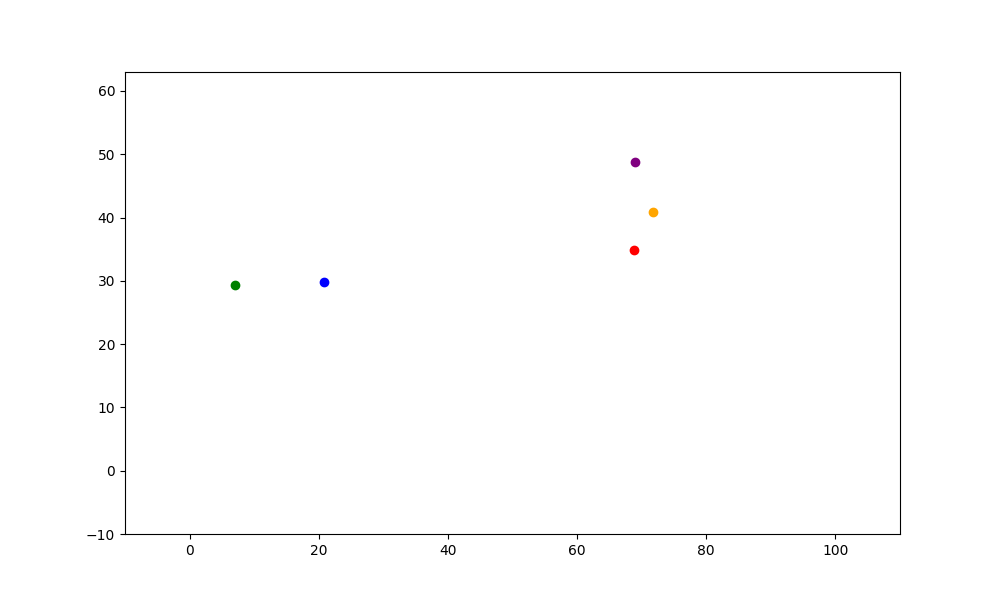

In [81]:
row = 1
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row]['x_x'][0]
football_y = model_data_df.iloc[row]['y_x'][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row]['x_x'][1]
punter_y = model_data_df.iloc[row]['y_x'][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row]['x_x'][2]
returner_y = model_data_df.iloc[row]['y_x'][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row]['x_y']
actual_y = model_data_df.iloc[row]['y_y']
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row]['prediction'][0]
predict_y = model_data_df.iloc[row]['prediction'][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [82]:
# Predict X
model_data_df['prediction'].str[0].describe()

count    1520.000000
mean       60.748908
std        28.365654
min        15.214778
25%        32.542552
50%        69.250679
75%        86.979837
max       104.364127
Name: prediction, dtype: float64

In [83]:
# Actual X
model_data_df['x_y'].describe()

count    1520.000000
mean       60.748908
std        29.003874
min        13.510000
25%        31.705000
50%        65.410000
75%        88.017500
max       109.640000
Name: x_y, dtype: float64

In [84]:
# Predict Y
model_data_df['prediction'].str[1].describe()

count    1520.000000
mean       26.898092
std         7.622615
min         1.374924
25%        21.050685
50%        26.859093
75%        32.747013
max        47.559128
Name: prediction, dtype: float64

In [85]:
# Actual Y
model_data_df['y_y'].describe()

count    1520.000000
mean       26.898092
std        13.138870
min        -8.400000
25%        16.285000
50%        27.430000
75%        37.675000
max        55.650000
Name: y_y, dtype: float64

In [86]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(23 * 2 * 10, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

model = get_model(X.shape[1], y.shape[1])

In [88]:
model.fit(X, y, verbose=1, epochs=1000)

Epoch 1/1000
48/48 [==============================] - 0s 1000us/step - loss: 3.1858
Epoch 2/1000
48/48 [==============================] - 0s 940us/step - loss: 3.4444
Epoch 3/1000
48/48 [==============================] - 0s 861us/step - loss: 3.2364
Epoch 4/1000
48/48 [==============================] - 0s 1ms/step - loss: 3.3244
Epoch 5/1000
48/48 [==============================] - 0s 961us/step - loss: 3.4019
Epoch 6/1000
48/48 [==============================] - 0s 856us/step - loss: 3.4118
Epoch 7/1000
48/48 [==============================] - 0s 1ms/step - loss: 3.8091
Epoch 8/1000
48/48 [==============================] - 0s 1ms/step - loss: 3.3908
Epoch 9/1000
48/48 [==============================] - 0s 1ms/step - loss: 3.3939
Epoch 10/1000
48/48 [==============================] - 0s 936us/step - loss: 3.1811
Epoch 11/1000
48/48 [==============================] - 0s 1ms/step - loss: 3.1680
Epoch 12/1000
48/48 [==============================] - 0s 922us/step - loss: 3.2193
Epoch 13/1

48/48 [==============================] - 0s 1ms/step - loss: 3.2139
Epoch 100/1000
48/48 [==============================] - 0s 946us/step - loss: 3.0893
Epoch 101/1000
48/48 [==============================] - 0s 1ms/step - loss: 3.0260
Epoch 102/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.9384
Epoch 103/1000
48/48 [==============================] - 0s 958us/step - loss: 3.0344
Epoch 104/1000
48/48 [==============================] - 0s 860us/step - loss: 3.1182
Epoch 105/1000
48/48 [==============================] - 0s 983us/step - loss: 3.0427
Epoch 106/1000
48/48 [==============================] - 0s 913us/step - loss: 3.0184
Epoch 107/1000
48/48 [==============================] - 0s 895us/step - loss: 3.4108
Epoch 108/1000
48/48 [==============================] - 0s 912us/step - loss: 3.0901
Epoch 109/1000
48/48 [==============================] - 0s 934us/step - loss: 3.0507
Epoch 110/1000
48/48 [==============================] - 0s 945us/step - loss: 3.2818
E

48/48 [==============================] - 0s 1ms/step - loss: 2.8588
Epoch 197/1000
48/48 [==============================] - 0s 944us/step - loss: 2.7427
Epoch 198/1000
48/48 [==============================] - 0s 942us/step - loss: 2.9349
Epoch 199/1000
48/48 [==============================] - 0s 934us/step - loss: 2.9236
Epoch 200/1000
48/48 [==============================] - 0s 882us/step - loss: 3.0491
Epoch 201/1000
48/48 [==============================] - 0s 894us/step - loss: 2.8822
Epoch 202/1000
48/48 [==============================] - 0s 968us/step - loss: 2.9086
Epoch 203/1000
48/48 [==============================] - 0s 907us/step - loss: 2.7909
Epoch 204/1000
48/48 [==============================] - 0s 914us/step - loss: 2.9287
Epoch 205/1000
48/48 [==============================] - 0s 906us/step - loss: 2.8743
Epoch 206/1000
48/48 [==============================] - 0s 961us/step - loss: 3.0452
Epoch 207/1000
48/48 [==============================] - 0s 863us/step - loss: 3.52

48/48 [==============================] - 0s 985us/step - loss: 3.0526
Epoch 293/1000
48/48 [==============================] - 0s 908us/step - loss: 3.1541
Epoch 294/1000
48/48 [==============================] - 0s 954us/step - loss: 3.1247
Epoch 295/1000
48/48 [==============================] - 0s 977us/step - loss: 2.9616
Epoch 296/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.8680
Epoch 297/1000
48/48 [==============================] - 0s 984us/step - loss: 2.9456
Epoch 298/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.9014
Epoch 299/1000
48/48 [==============================] - 0s 891us/step - loss: 2.8706
Epoch 300/1000
48/48 [==============================] - 0s 972us/step - loss: 2.8666
Epoch 301/1000
48/48 [==============================] - 0s 969us/step - loss: 2.8812
Epoch 302/1000
48/48 [==============================] - 0s 912us/step - loss: 2.6957
Epoch 303/1000
48/48 [==============================] - 0s 973us/step - loss: 2.8445

48/48 [==============================] - 0s 1ms/step - loss: 2.8311
Epoch 390/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.7092
Epoch 391/1000
48/48 [==============================] - 0s 993us/step - loss: 2.5820
Epoch 392/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.6495
Epoch 393/1000
48/48 [==============================] - 0s 945us/step - loss: 2.6743
Epoch 394/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.8026
Epoch 395/1000
48/48 [==============================] - 0s 974us/step - loss: 3.3142
Epoch 396/1000
48/48 [==============================] - 0s 949us/step - loss: 2.9752
Epoch 397/1000
48/48 [==============================] - 0s 979us/step - loss: 2.8472
Epoch 398/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.6946
Epoch 399/1000
48/48 [==============================] - 0s 909us/step - loss: 2.8762
Epoch 400/1000
48/48 [==============================] - 0s 916us/step - loss: 2.7061
Epoch

48/48 [==============================] - 0s 964us/step - loss: 2.5732
Epoch 486/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.4659
Epoch 487/1000
48/48 [==============================] - 0s 928us/step - loss: 2.5022
Epoch 488/1000
48/48 [==============================] - 0s 861us/step - loss: 2.6786
Epoch 489/1000
48/48 [==============================] - 0s 933us/step - loss: 2.5540
Epoch 490/1000
48/48 [==============================] - 0s 929us/step - loss: 2.4559
Epoch 491/1000
48/48 [==============================] - 0s 897us/step - loss: 2.3947
Epoch 492/1000
48/48 [==============================] - 0s 909us/step - loss: 2.7774
Epoch 493/1000
48/48 [==============================] - 0s 957us/step - loss: 2.8045
Epoch 494/1000
48/48 [==============================] - 0s 889us/step - loss: 2.7215
Epoch 495/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.8000
Epoch 496/1000
48/48 [==============================] - 0s 868us/step - loss: 2.7050

48/48 [==============================] - 0s 1ms/step - loss: 2.7235
Epoch 582/1000
48/48 [==============================] - 0s 904us/step - loss: 2.4589
Epoch 583/1000
48/48 [==============================] - 0s 979us/step - loss: 2.4634
Epoch 584/1000
48/48 [==============================] - 0s 922us/step - loss: 2.5977
Epoch 585/1000
48/48 [==============================] - 0s 953us/step - loss: 2.5640
Epoch 586/1000
48/48 [==============================] - 0s 830us/step - loss: 2.6408
Epoch 587/1000
48/48 [==============================] - 0s 945us/step - loss: 2.4102
Epoch 588/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.6067
Epoch 589/1000
48/48 [==============================] - 0s 985us/step - loss: 2.8582
Epoch 590/1000
48/48 [==============================] - 0s 999us/step - loss: 2.6661
Epoch 591/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.6608
Epoch 592/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.4173
Epo

Epoch 678/1000
48/48 [==============================] - 0s 851us/step - loss: 2.4814
Epoch 679/1000
48/48 [==============================] - 0s 886us/step - loss: 2.5681
Epoch 680/1000
48/48 [==============================] - 0s 985us/step - loss: 2.3866
Epoch 681/1000
48/48 [==============================] - 0s 967us/step - loss: 2.3834
Epoch 682/1000
48/48 [==============================] - 0s 960us/step - loss: 2.2967
Epoch 683/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.4529
Epoch 684/1000
48/48 [==============================] - 0s 1ms/step - loss: 2.4419
Epoch 685/1000
48/48 [==============================] - 0s 910us/step - loss: 2.5232
Epoch 686/1000
48/48 [==============================] - 0s 992us/step - loss: 2.2658
Epoch 687/1000
48/48 [==============================] - 0s 952us/step - loss: 2.3997
Epoch 688/1000
48/48 [==============================] - 0s 929us/step - loss: 2.5485
Epoch 689/1000
48/48 [==============================] - 0s 970us/step

Epoch 775/1000
48/48 [==============================] - 0s 938us/step - loss: 2.5493
Epoch 776/1000
48/48 [==============================] - 0s 906us/step - loss: 2.3749
Epoch 777/1000
48/48 [==============================] - 0s 865us/step - loss: 2.3556
Epoch 778/1000
48/48 [==============================] - 0s 935us/step - loss: 2.3885
Epoch 779/1000
48/48 [==============================] - 0s 950us/step - loss: 2.3673
Epoch 780/1000
48/48 [==============================] - 0s 843us/step - loss: 2.5214
Epoch 781/1000
48/48 [==============================] - 0s 922us/step - loss: 2.3519
Epoch 782/1000
48/48 [==============================] - 0s 930us/step - loss: 2.3147
Epoch 783/1000
48/48 [==============================] - 0s 899us/step - loss: 2.3331
Epoch 784/1000
48/48 [==============================] - 0s 865us/step - loss: 2.4184
Epoch 785/1000
48/48 [==============================] - 0s 905us/step - loss: 2.5635
Epoch 786/1000
48/48 [==============================] - 0s 905us/

48/48 [==============================] - 0s 917us/step - loss: 2.3706
Epoch 872/1000
48/48 [==============================] - 0s 997us/step - loss: 2.3024
Epoch 873/1000
48/48 [==============================] - 0s 944us/step - loss: 2.4922
Epoch 874/1000
48/48 [==============================] - 0s 921us/step - loss: 2.4978
Epoch 875/1000
48/48 [==============================] - 0s 859us/step - loss: 2.2664
Epoch 876/1000
48/48 [==============================] - 0s 906us/step - loss: 2.4677
Epoch 877/1000
48/48 [==============================] - 0s 858us/step - loss: 2.4450
Epoch 878/1000
48/48 [==============================] - 0s 870us/step - loss: 2.6139
Epoch 879/1000
48/48 [==============================] - 0s 894us/step - loss: 2.3889
Epoch 880/1000
48/48 [==============================] - 0s 893us/step - loss: 2.4451
Epoch 881/1000
48/48 [==============================] - 0s 869us/step - loss: 2.3161
Epoch 882/1000
48/48 [==============================] - 0s 920us/step - loss: 2.

48/48 [==============================] - 0s 901us/step - loss: 2.1969
Epoch 968/1000
48/48 [==============================] - 0s 897us/step - loss: 2.1620
Epoch 969/1000
48/48 [==============================] - 0s 873us/step - loss: 2.3376
Epoch 970/1000
48/48 [==============================] - 0s 949us/step - loss: 2.2124
Epoch 971/1000
48/48 [==============================] - 0s 845us/step - loss: 2.1576
Epoch 972/1000
48/48 [==============================] - 0s 893us/step - loss: 2.2520
Epoch 973/1000
48/48 [==============================] - 0s 920us/step - loss: 2.6138
Epoch 974/1000
48/48 [==============================] - 0s 920us/step - loss: 2.3664
Epoch 975/1000
48/48 [==============================] - 0s 850us/step - loss: 2.2402
Epoch 976/1000
48/48 [==============================] - 0s 854us/step - loss: 2.2994
Epoch 977/1000
48/48 [==============================] - 0s 899us/step - loss: 2.3819
Epoch 978/1000
48/48 [==============================] - 0s 802us/step - loss: 2.

In [89]:
model_data_df['nn_prediction'] = model.predict(X).tolist()

<IPython.core.display.Javascript object>


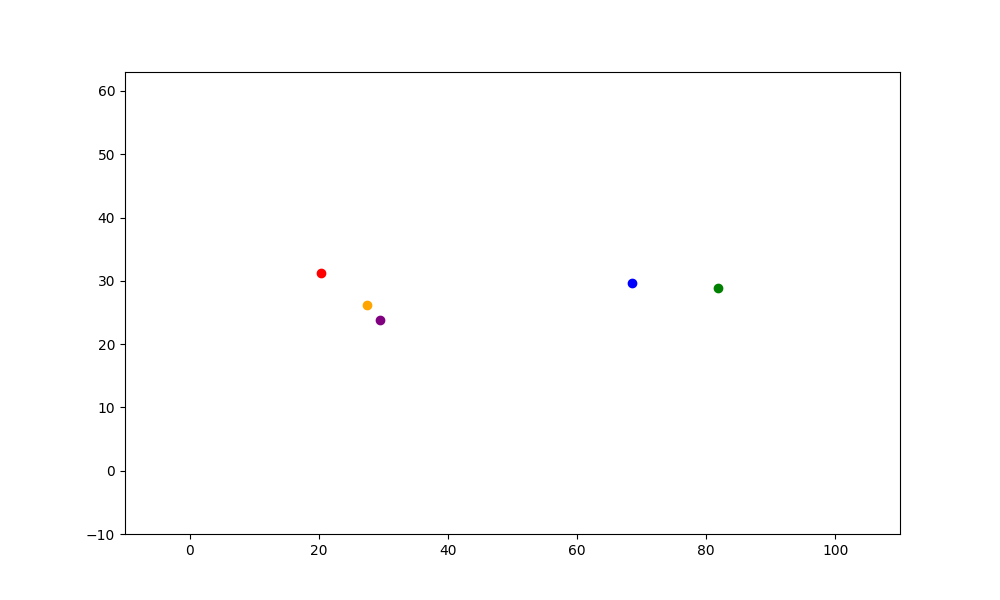

In [92]:
row = 3
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
c = 'blue'
football_x = model_data_df.iloc[row]['x_x'][0]
football_y = model_data_df.iloc[row]['y_x'][0]
ax.scatter(x=football_x, y=football_y, c=c)
c = 'green'
punter_x = model_data_df.iloc[row]['x_x'][1]
punter_y = model_data_df.iloc[row]['y_x'][1]
ax.scatter(x=punter_x, y=punter_y, c=c)
c = 'red'
returner_x = model_data_df.iloc[row]['x_x'][2]
returner_y = model_data_df.iloc[row]['y_x'][2]
ax.scatter(x=returner_x, y=returner_y, c=c)
c = 'purple'
actual_x = model_data_df.iloc[row]['x_y']
actual_y = model_data_df.iloc[row]['y_y']
ax.scatter(x=actual_x, y=actual_y, c=c)
c = 'orange'
predict_x = model_data_df.iloc[row]['nn_prediction'][0]
predict_y = model_data_df.iloc[row]['nn_prediction'][1]
ax.scatter(x=predict_x, y=predict_y, c=c)
plt.show()

In [93]:
model_data_df['linearRegressionAbsoluteError'] = (
    (model_data_df['x_y'] - model_data_df['prediction'].str[0]) ** 2 +
    (model_data_df['y_y'] - model_data_df['prediction'].str[1]) ** 2
) ** 0.5
model_data_df['neuralNetworkAbsoluteError'] = (
    (model_data_df['x_y'] - model_data_df['nn_prediction'].str[0]) ** 2 +
    (model_data_df['y_y'] - model_data_df['nn_prediction'].str[1]) ** 2
) ** 0.5

In [94]:
model_data_df['linearRegressionAbsoluteError'].mean()

10.79848610495994

In [95]:
model_data_df['neuralNetworkAbsoluteError'].mean()

3.268373229221847